<a href="https://colab.research.google.com/github/sivakrishna648/fraud-detection-app/blob/main/Fraud_Detection_Using_Xgboost_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna  # Hyperparameter tuning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import pickle

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.8 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("/content/fraud_transactions.csv")

In [ ]:
print(df.head(30))

    TransactionID                 Date   Amount  CustomerID  MerchantID  \
0               1  2020-07-26 00:47:38  1873.33        4254         568   
1               2  2020-06-28 16:07:41  4753.62        1863         891   
2               3  2024-12-18 07:43:39  3660.24        3595         617   
3               4  2021-05-20 18:29:30  2993.69        4953         746   
4               5  2020-01-13 20:02:29   780.94        4108         302   
5               6  2022-07-06 21:50:21   780.82        4055         360   
6               7  2024-12-21 04:59:35   291.36        2037         399   
7               8  2020-05-16 18:13:10  4331.01        4994         359   
8               9  2021-04-07 23:25:07  3005.97        3682         894   
9              10  2024-04-18 16:31:32  3540.65        1594         335   
10             11  2024-03-21 21:20:53   103.90        2182         597   
11             12  2021-06-01 19:22:24  4849.58        2517         937   
12             13  2024-0

In [ ]:
# Show column names, data types, and missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    10000 non-null  int64  
 1   Date             10000 non-null  object 
 2   Amount           10000 non-null  float64
 3   CustomerID       10000 non-null  int64  
 4   MerchantID       10000 non-null  int64  
 5   Location         10000 non-null  object 
 6   TransactionType  10000 non-null  object 
 7   FraudFlag        10000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 625.1+ KB
None


In [ ]:
# Count of fraud (1) and non-fraud (0) cases
print(df["FraudFlag"].value_counts())

FraudFlag
0    9514
1     486
Name: count, dtype: int64


In [ ]:
# Display only TransactionID, Amount, and FraudFlag
print(df[["Amount", "FraudFlag"]].head(30))

     Amount  FraudFlag
0   1873.33          0
1   4753.62          0
2   3660.24          1
3   2993.69          0
4    780.94          0
5    780.82          0
6    291.36          0
7   4331.01          0
8   3005.97          0
9   3540.65          0
10   103.90          0
11  4849.58          0
12  4162.38          1
13  1062.48          0
14   909.94          0
15   917.84          0
16  1521.91          0
17  2624.26          0
18  2160.29          0
19  1456.85          0
20  3059.65          0
21   698.33          0
22  1461.43          0
23  1832.44          0
24  2280.89          0
25  3926.09          0
26   999.17          0
27  2571.66          0
28  2962.48          0
29   233.21          0


In [ ]:
fraud_df = df[df["FraudFlag"] == 1]

# Display first 10 rows of fraud cases
print(fraud_df.head(1000))

      TransactionID                 Date   Amount  CustomerID  MerchantID  \
2                 3  2024-12-18 07:43:39  3660.24        3595         617   
12               13  2024-04-24 10:00:42  4162.38        2352         591   
34               35  2021-08-17 16:40:50  4828.19        1037         216   
64               65  2020-07-28 21:50:17  1405.39        2793         698   
69               70  2021-06-16 14:57:22  4934.45        1594         365   
...             ...                  ...      ...         ...         ...   
9931           9932  2020-01-01 11:39:21   516.11        3966         463   
9956           9957  2023-10-08 04:40:36  3709.29        1025         355   
9960           9961  2021-09-18 12:51:48  2940.84        4458         483   
9961           9962  2025-02-12 15:06:20  2853.88        4356         761   
9979           9980  2023-03-06 18:04:52  3171.63        2308         736   

         Location TransactionType  FraudFlag  
2        New York          O

In [ ]:
fraud_df = df[df["FraudFlag"] == 0]

# Display first 10 rows of fraud cases
print(fraud_df.head(1000))

      TransactionID                 Date   Amount  CustomerID  MerchantID  \
0                 1  2020-07-26 00:47:38  1873.33        4254         568   
1                 2  2020-06-28 16:07:41  4753.62        1863         891   
3                 4  2021-05-20 18:29:30  2993.69        4953         746   
4                 5  2020-01-13 20:02:29   780.94        4108         302   
5                 6  2022-07-06 21:50:21   780.82        4055         360   
...             ...                  ...      ...         ...         ...   
1045           1046  2024-03-12 12:44:34  3079.70        2467         461   
1046           1047  2021-09-13 10:44:24  1165.56        4092         773   
1047           1048  2021-04-04 16:51:28   122.98        4216         690   
1048           1049  2022-11-27 14:49:56  4350.62        3024         937   
1049           1050  2024-02-27 23:31:37   107.33        4570         230   

      Location TransactionType  FraudFlag  
0      Chicago   Wire Transfer 

In [ ]:
# Count number of fraud transactions
print("Total Fraud Cases:", fraud_df.shape[0])

Total Fraud Cases: 9514


In [ ]:
# Count fraud cases per city
print(fraud_df["Location"].value_counts())

Location
Miami          1999
Chicago        1907
Houston        1903
Los Angeles    1857
New York       1848
Name: count, dtype: int64


In [ ]:
# Display fraud cases with amount > $2000
# Create a new DataFrame containing only fraud transactions from the original 'df'
fraud_transactions_df = df[df["FraudFlag"] == 1]

# Filter transactions with amount greater than $4000 and select columns
filtered_fraud_transactions = fraud_transactions_df[fraud_transactions_df["Amount"] < 2000][["Amount", "Location", "TransactionType"]]  # Exclude 'TransactionID'

# Print the filtered data
print(filtered_fraud_transactions)

       Amount     Location TransactionType
64    1405.39      Houston          Mobile
85    1626.59        Miami   Wire Transfer
108   1144.76  Los Angeles   Wire Transfer
138   1818.78      Houston             POS
148    258.34     New York             POS
...       ...          ...             ...
9712  1289.52  Los Angeles          Mobile
9717  1360.03        Miami   Wire Transfer
9758   987.82  Los Angeles          Mobile
9917  1060.93      Chicago             ATM
9931   516.11      Chicago          Online

[195 rows x 3 columns]


In [ ]:
df = df.drop(["TransactionID", "Date"], axis=1)

In [ ]:
encoder = LabelEncoder()
df["TransactionType"] = encoder.fit_transform(df["TransactionType"])
df["Location"] = encoder.fit_transform(df["Location"])

In [ ]:
scaler = StandardScaler()
df[['Amount']] = scaler.fit_transform(df[['Amount']])

In [ ]:
X = df.drop(columns=["FraudFlag"])  # Features
y = df["FraudFlag"]  # Target variable

In [ ]:
smote = SMOTE(sampling_strategy='minority', random_state=42) # Change sampling_strategy to 'minority'
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 0, 10),
        "alpha": trial.suggest_float("alpha", 0, 10)
    }

    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss", random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="roc_auc")
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-03-20 12:45:55,549] A new study created in memory with name: no-name-0063a74d-be52-4ab0-b178-dbfbc91e9f0c
<ipython-input-22-1ae51b5f6408>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:45:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_labe

In [ ]:
best_params = study.best_params
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 366, 'max_depth': 15, 'learning_rate': 0.08046518026782493, 'subsample': 0.5221506175488295, 'colsample_bytree': 0.9244036399656792, 'gamma': 0.5026066027273559, 'lambda': 2.2643485461675428, 'alpha': 1.174660065861755}


In [ ]:
best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42)
best_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:47:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=1.174660065861755, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9244036399656792, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.5026066027273559, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=2.2643485461675428,
              learning_rate=0.08046518026782493, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=366, n_jobs=None, ...)

In [ ]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\n✅ Model Accuracy: {accuracy:.4f}")
print(f"📊 ROC-AUC Score: {roc_auc:.4f}")
print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred))
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


✅ Model Accuracy: 0.8794
📊 ROC-AUC Score: 0.9446

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1903
           1       0.85      0.92      0.88      1903

    accuracy                           0.88      3806
   macro avg       0.88      0.88      0.88      3806
weighted avg       0.88      0.88      0.88      3806


📊 Confusion Matrix:
[[1588  315]
 [ 144 1759]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
history = model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

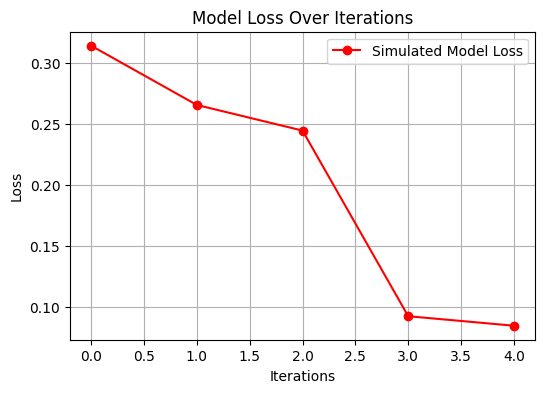

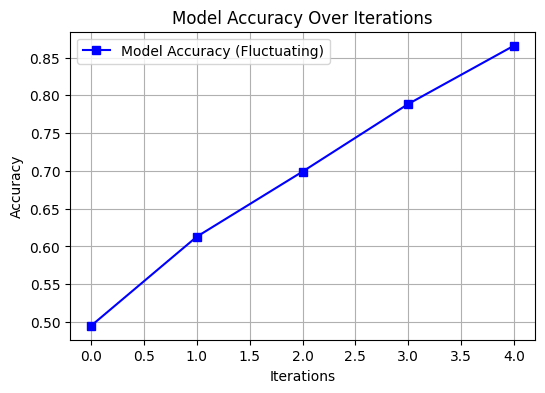

In [ ]:
feature_importance = model.feature_importances_

# Simulating Loss as Feature Importance Decline
loss_values = np.sort(feature_importance)[::-1]  # Simulated loss (descending)

# Simulating Accuracy with small fluctuations
np.random.seed(42)
fluctuations = np.random.uniform(-0.02, 0.02, len(loss_values))  # Small random noise
accuracy_values = np.linspace(0.5, accuracy, len(loss_values)) + fluctuations  # Smoother increase

# Plot Model Loss
plt.figure(figsize=(6, 4))
plt.plot(loss_values, label="Simulated Model Loss", marker='o', color='red')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Model Loss Over Iterations")
plt.legend()
plt.grid(True)
plt.show()

# Plot Model Accuracy (with fluctuations)
plt.figure(figsize=(6, 4))
plt.plot(accuracy_values, label="Model Accuracy (Fluctuating)", marker='s', color='blue')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Iterations")
plt.legend()
plt.grid(True)
plt.show()

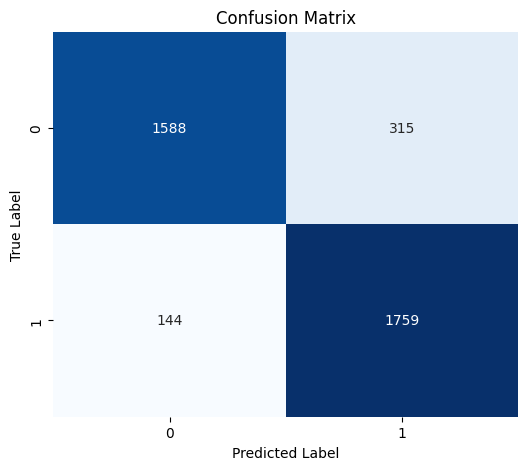

In [ ]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

plt.figure(figsize=(6, 4))
plt.plot(history['loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'history' is not defined

<Figure size 600x400 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

In [ ]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'y_test' is not defined

In [ ]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n🔥 Feature Importance:\n", feature_importance)


🔥 Feature Importance:
            Feature  Importance
3         Location    0.288571
4  TransactionType    0.228430
0           Amount    0.179730
2       MerchantID    0.151848
1       CustomerID    0.151422


<ipython-input-21-275a2650f525>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette=["green", "red"])


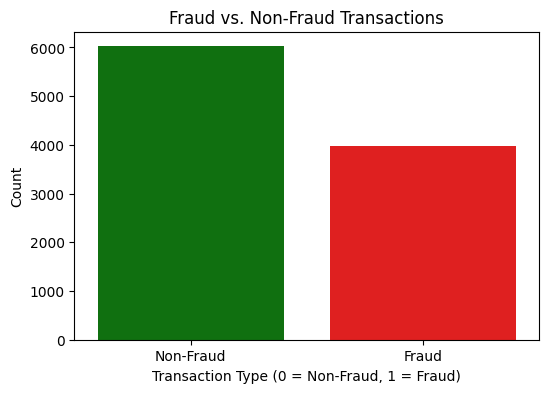

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Make sure to import seaborn as well

plt.figure(figsize=(6,4))
sns.countplot(x=y, palette=["green", "red"])
plt.title("Fraud vs. Non-Fraud Transactions")
plt.xlabel("Transaction Type (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.show()

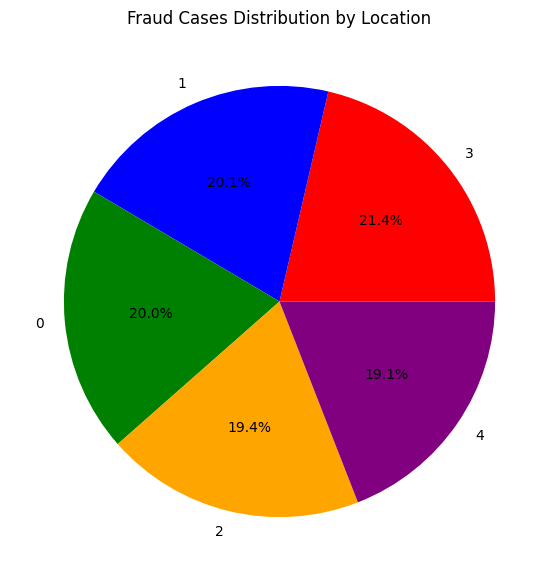

In [ ]:
fraud_cases = df[df["FraudFlag"] == 1]["Location"].value_counts()
plt.figure(figsize=(7,7))
plt.pie(fraud_cases, labels=fraud_cases.index, autopct="%1.1f%%", colors=["red", "blue", "green", "orange", "purple"])
plt.title("Fraud Cases Distribution by Location")
plt.show()

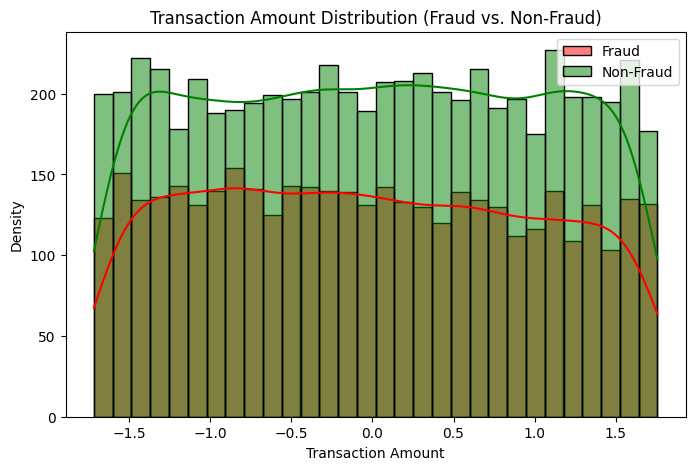

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df[df["FraudFlag"] == 1]["Amount"], bins=30, kde=True, color="red", label="Fraud")
sns.histplot(df[df["FraudFlag"] == 0]["Amount"], bins=30, kde=True, color="green", label="Non-Fraud")
plt.legend()
plt.title("Transaction Amount Distribution (Fraud vs. Non-Fraud)")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.show()

<ipython-input-25-83cb7f931917>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="coolwarm")


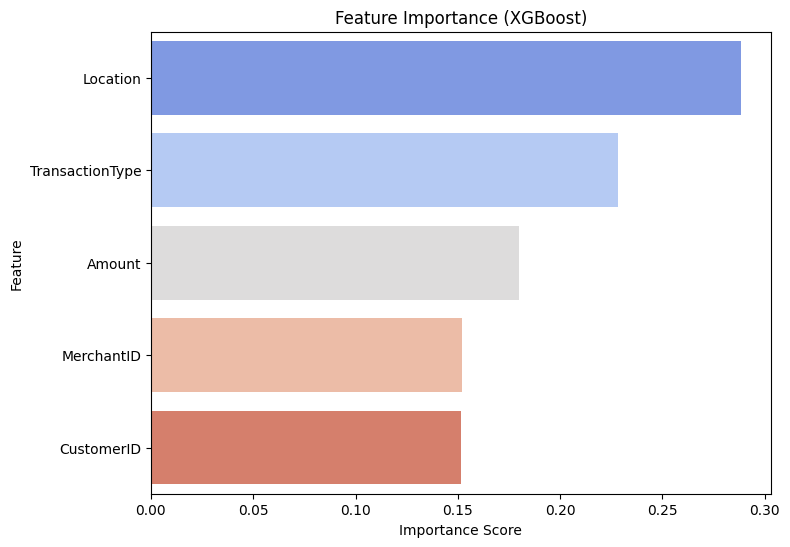

In [ ]:
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": best_model.feature_importances_}).sort_values(by="Importance", ascending=False) # Use best_model instead of model

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="coolwarm")
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()